### Goal
Predict if a passenger survived the sinking of the Titanic or not. 

### Python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Read and describe the training data

In [2]:
raw_data = pd.read_csv('train.csv')
raw_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
raw_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Probability of survival for class and sex

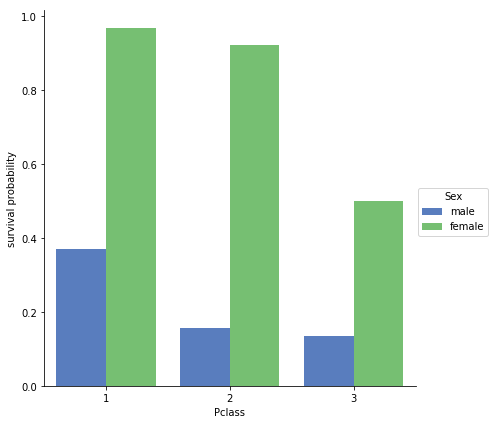

In [4]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=raw_data, size=6, kind='bar', palette='muted', ci=None)

g.set_ylabels('survival probability')

#### Survival percentage per group

In [5]:
max_child_age = 12
total = float(len(raw_data))

survived = raw_data[raw_data['Survived'] == True]
female = raw_data[raw_data['Sex'] == 'female']
male = raw_data[raw_data['Sex'] == 'male']
male_child = raw_data[(raw_data['Sex'] == 'male') & (raw_data['Age'] <= max_child_age)]
male_adult = raw_data[(raw_data['Sex'] == 'male') & (raw_data['Age'] > max_child_age)]
select_woman_or_child = (raw_data['Sex'] == 'female') | (raw_data['Age'] <= max_child_age)
woman_or_child = raw_data[select_woman_or_child]
not_woman_or_child = raw_data[~select_woman_or_child]

print('From %d passengers %d%% (%d) survived.' % (total, raw_data.Survived.mean() * 100, len(survived)))
print('Female: %d%% (%d)' % (female.Survived.mean() * 100, len(female)))
print('Male: %d%% (%d)' % (male.Survived.mean() * 100, len(male)))
print('Male and child: %d%% (%d)' % (male_child.Survived.mean() * 100, len(male_child)))
print('Female or child: %d%% (%d)' % (woman_or_child.Survived.mean() * 100, len(woman_or_child)))
print('Not (Female or child): %d%% (%d)' % (not_woman_or_child.Survived.mean() * 100, len(not_woman_or_child)))

From 891 passengers 38% (342) survived.
Female: 74% (314)
Male: 18% (577)
Male and child: 56% (37)
Female or child: 72% (351)
Not (Female or child): 16% (540)


#### Prediction and accuracy

In [6]:
no_one_survived = total - len(survived)
woman_survived = len(female[female.Survived == True]) + len(male[male.Survived == False])
woman_or_child_survived = len(woman_or_child[woman_or_child.Survived == True]) + \
                          len(not_woman_or_child[not_woman_or_child.Survived == False])

print('No one will survive: %.2f' % (no_one_survived * 100 / total))
print('Woman will survive: %.2f' % (woman_survived * 100 / total))
print('Woman and children will survive: %.2f' % (woman_or_child_survived * 100 / total))

No one will survive: 61.62
Woman will survive: 78.68
Woman and children will survive: 79.24


### Baseline prediction with ~ 79.24% accuracy:  All woman and children will survive!

### Prepare the data
#### One-hot encoding

In [7]:
data = raw_data.copy()
pclass = pd.get_dummies(raw_data.Pclass, prefix='c')
embarked = pd.get_dummies(raw_data.Embarked, prefix='Embarked')
data['Sex'] = data['Sex'] == 'male'

data = pd.concat([data, pclass, embarked], axis=1)
data.rename(columns={'Sex': 'Is_male', 'c_1': 'Class_upper', 'c_2': 'Class_middle', 'c_3': 'Class_lower'}, inplace=True)
data = data.drop(columns=['Pclass', 'Embarked'])
data.head(3)

,PassengerId,Survived,Name,Is_male,Age,SibSp,Parch,Ticket,Fare,Cabin,Class_upper,Class_middle,Class_lower,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",True,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",False,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,0,1


#### English honorifics in Name

In [8]:
print('Total passengers:', len(raw_data))
print('Mr.', len(raw_data[raw_data.Name.str.contains('Mr\.')]))
print('Miss.', len(raw_data[raw_data.Name.str.contains('Miss\.')]))
print('Mrs.', len(raw_data[raw_data.Name.str.contains('Mrs\.')]))
print('Master.', len(raw_data[raw_data.Name.str.contains('Master\.')]))
print('Dr', len(raw_data[raw_data.Name.str.contains('Dr')]))
print('Sir', len(raw_data[raw_data.Name.str.contains('Sir')]))
print('Ms', len(raw_data[raw_data.Name.str.contains('Ms')]))
print('Lady', len(raw_data[raw_data.Name.str.contains('Lady')]))
print('Lord', len(raw_data[raw_data.Name.str.contains('Lord')]))
print('General', len(raw_data[raw_data.Name.str.contains('General')]))
print('Captain', len(raw_data[raw_data.Name.str.contains('Captain')]))

Total passengers: 891
Mr. 517
Miss. 182
Mrs. 125
Master. 40
Dr 11
Sir 3
Ms 1
Lady 1
Lord 0
General 0
Captain 0


In [9]:
data['Mr'] = data.Name.str.contains('Mr\.')
data['Miss'] = data.Name.str.contains('Miss\.')
data['Mrs'] = data.Name.str.contains('Mrs\.')
data['Master'] = data.Name.str.contains('Master\.')

data[['Name', 'Mr', 'Miss', 'Mrs', 'Master']].head(8)

,Name,Mr,Miss,Mrs,Master
0,"Braund, Mr. Owen Harris",True,False,False,False
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",False,False,True,False
2,"Heikkinen, Miss. Laina",False,True,False,False
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",False,False,True,False
4,"Allen, Mr. William Henry",True,False,False,False
5,"Moran, Mr. James",True,False,False,False
6,"McCarthy, Mr. Timothy J",True,False,False,False
7,"Palsson, Master. Gosta Leonard",False,False,False,True


In [10]:
data['Age_is_null'] = data.Age.isnull()
print(len(data[data.Age_is_null == True]), 'passengers are without age.')

177 passengers are without age.


In [11]:
data['Deck_a'] = raw_data.Cabin.str.contains('A', na=False)
data['Deck_b'] = raw_data.Cabin.str.contains('B', na=False)
data['Deck_c'] = raw_data.Cabin.str.contains('C', na=False)
data['Deck_d'] = raw_data.Cabin.str.contains('D', na=False)
data['Deck_e'] = raw_data.Cabin.str.contains('E', na=False)
data['Deck_f'] = raw_data.Cabin.str.contains('F', na=False)
data['Deck_g'] = raw_data.Cabin.str.contains('G', na=False)

#### Split data into features and labels

In [12]:
from sklearn.preprocessing import Imputer

# Convert to numpy array
y = np.array(data.Survived)

X = data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X.head(6)

,Is_male,Age,SibSp,Parch,Fare,Class_upper,Class_middle,Class_lower,Embarked_C,Embarked_Q,...,Mrs,Master,Age_is_null,Deck_a,Deck_b,Deck_c,Deck_d,Deck_e,Deck_f,Deck_g
0,True,22.0,1,0,7.2500,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
1,False,38.0,1,0,71.2833,1,0,0,1,0,...,True,False,False,False,False,True,False,False,False,False
2,False,26.0,0,0,7.9250,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
3,False,35.0,1,0,53.1000,1,0,0,0,0,...,True,False,False,False,False,True,False,False,False,False
4,True,35.0,0,0,8.0500,0,0,1,0,0,...,False,False,False,False,False,False,False,False,False,False
5,True,NaN,0,0,8.4583,0,0,1,0,1,...,False,False,True,False,False,False,False,False,False,False


In [13]:
X_columns = list(X.columns)
X = np.array(X)

# Create our imputer to replace missing values with the mean e.g.
imp = Imputer(missing_values='NaN', strategy='mean')
imp = imp.fit(X)

# Impute our data
X = imp.transform(X)

my_random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_random_state)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape ', X_test.shape)
print('y_test shape ', y_test.shape)

X_train shape (668, 23)
y_train shape (668,)
X_test shape  (223, 23)
y_test shape  (223,)


### Train Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=my_random_state)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Predict

In [15]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

print('Accuracy: %.2f' % (100 - sum(errors) * 100 / len(errors)))

Accuracy: 80.27


#### Feature importances

In [16]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
# Print out the feature and importance's 
feature_importances

[('Fare', 0.21),
 ('Age', 0.19),
 ('Mr', 0.12),
 ('Is_male', 0.11),
 ('SibSp', 0.05),
 ('Class_lower', 0.05),
 ('Mrs', 0.04),
 ('Parch', 0.03),
 ('Miss', 0.03),
 ('Class_upper', 0.02),
 ('Class_middle', 0.02),
 ('Embarked_S', 0.02),
 ('Age_is_null', 0.02),
 ('Embarked_C', 0.01),
 ('Embarked_Q', 0.01),
 ('Master', 0.01),
 ('Deck_b', 0.01),
 ('Deck_c', 0.01),
 ('Deck_d', 0.01),
 ('Deck_e', 0.01),
 ('Deck_a', 0.0),
 ('Deck_f', 0.0),
 ('Deck_g', 0.0)]

#### Visualizing a Single Decision Tree

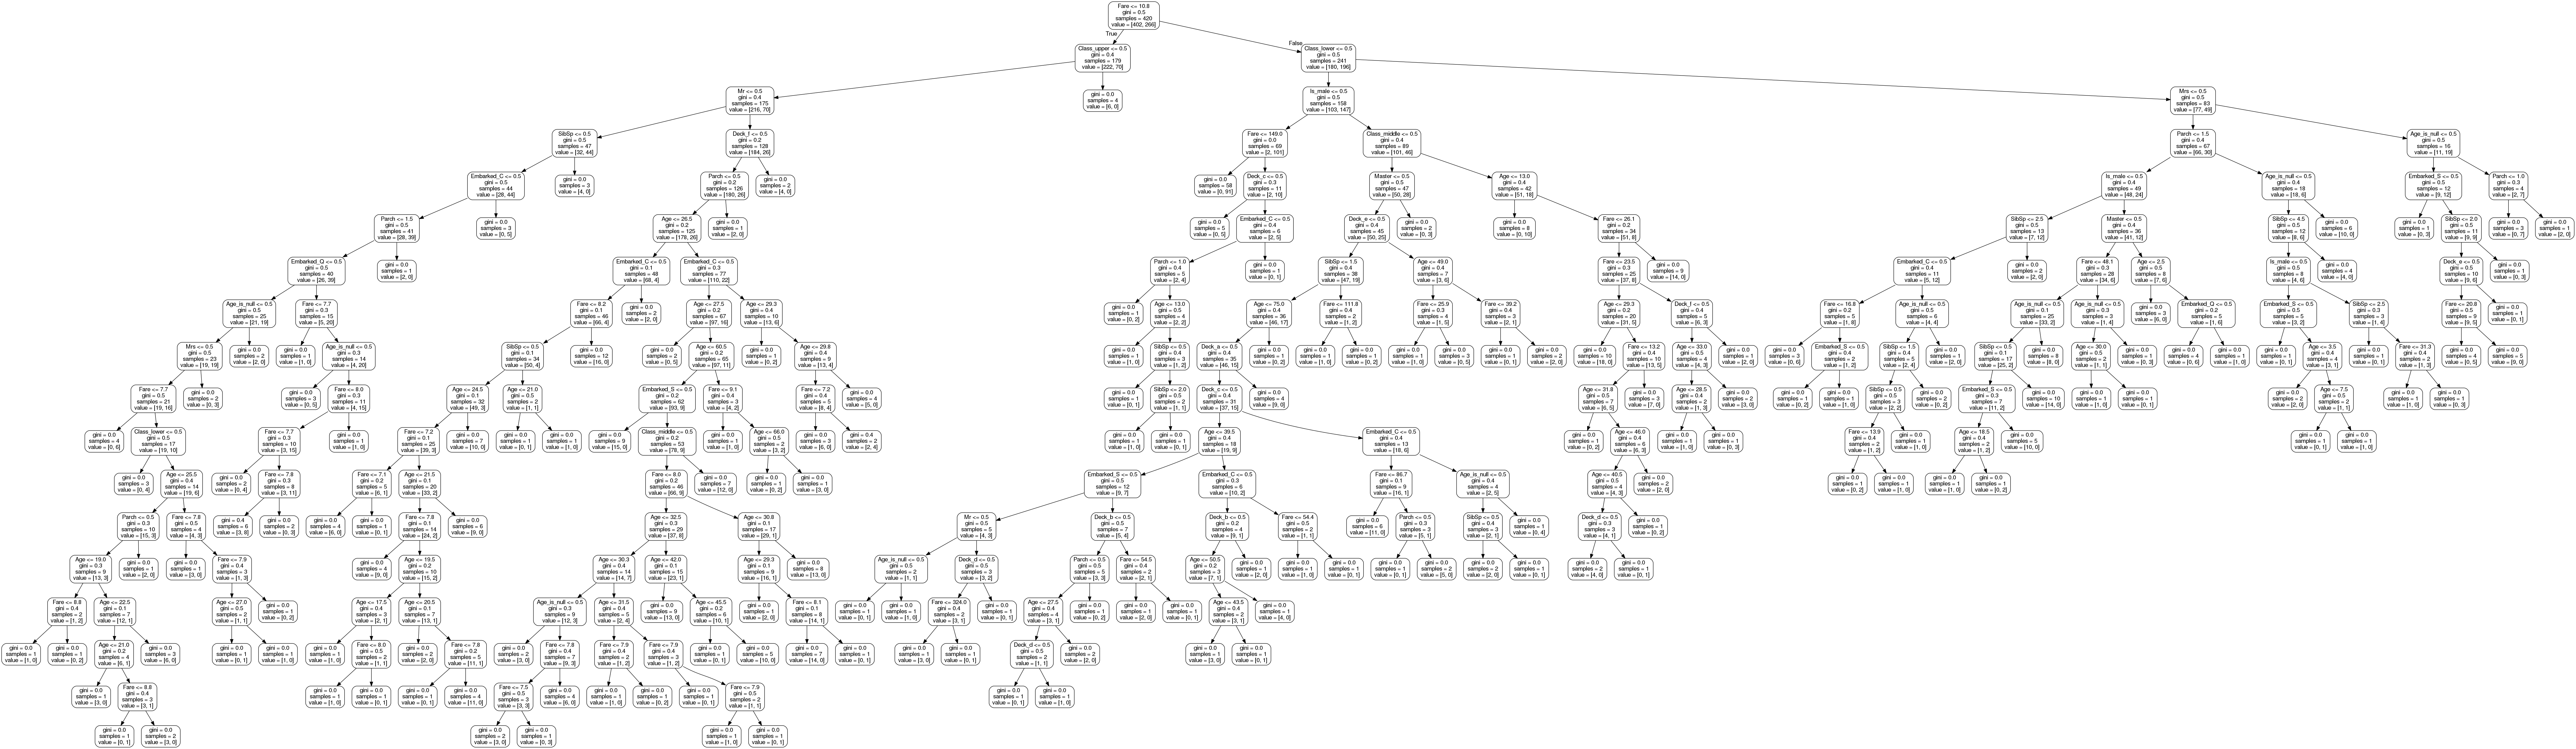

In [17]:
# To install missing packages, run in terminal:
# conda install graphviz pydot
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[1]

# Export the image to a dot file
export_graphviz(tree, out_file='tree.dot', feature_names=X_columns, rounded=True, precision=1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

# Display the image
from IPython.display import Image
Image("tree.png")